# Example: Assigning new patients to phenotypes
We identified 4 clusters in RA (Rheumatoid arthritis) with deep embedded clustering on tabular lab & clinical data. However, to ensure that this isnt just an incidental finding, we recruit a different set of patients for replication. We apply the autoencoder model trained on the initial development set to project these new patients on the learned latent space. Given their orientiation, and their closest neighbours* (patients presenting with the same clinical characteristics from the initial set), we can provide each new patient with a cluster label.

*Another name for these neighbours is: digital twins.  

#### Difference in dimensionality
In this example, there is a difference in dimensionality between the development set and the replication set. Hence, we build a reduced latent space with the features we know to be present in both datasets. Whereby, the original clustering information, defined on the complete data from the development set, remains in tact. We will use the original clustering information to assign the new patients instead of re-clustering with incomplete data, as we assume that the essence of each cluster is preserved in this reduced space.  

Be careful though: If clinical data is absent in the external set (like this example), one should ensure that at least the key-features are present. Otherwise, the tool will render non-sensible output. You'll find some visualization tools down below to detect the differences in quality.

## Step 1. Construct shared product space 
### 1.1 Import data
We import data from both the development set as well as the replication set. Each set has two different data modalities (numerical and categorical features), which are saved in seperate tables. Hence, we open 4 files in total.

### 1.1 Import data
We import data from both the development set as well as the replication set. Each set has two different data modalities (numerical and categorical features), which are saved in seperate tables. Hence, we open 4 files in total.


In [1]:
import numpy as np
import pandas as pd

# Set seed
np.random.seed(0)

# Variables from development set
df_numeric = pd.read_csv('../example_data/development/ClusteringDEV_NUMERIC.csv', sep=',')#[['Leuko', 'MCH', 'Hb', 'Ht', 'MCHC',  'MCV', 'Trom', 'BSE', 'Age']] # 
df_categoric= pd.read_csv('../example_data/development/ClusteringDEV_CATEGORICAL.csv', sep=',')

# Load modalities from replication set
df_categoric_replication = pd.read_csv('../example_data/replication/ClusteringIMPROVED_CATEGORICAL.csv', sep='|')
df_numeric_replication = pd.read_csv('../example_data/replication/ClusteringIMPROVED_NUMERIC.csv', sep='|')#[['Leuko', 'Hb',   'MCV', 'Trom', 'BSE',  'Age']]
df_numeric_replication_un = pd.read_csv('../example_data/replication/ClusteringIMPROVED_NUMERIC2.csv', sep='|')#[['Leuko', 'Hb',   'MCV', 'Trom', 'BSE',  'Age']]


# Original clustering information (same samples as development set)
df_cluster = pd.read_csv('../example_data/development/ClusteringDEV_INFO.csv')[['pseudoId', 'PhenoGraph_clusters']]

## #2. Project new data

Load different custom env: 
conda activate /exports/reum/tdmaarseveen/envs/mmae/envs/ae_training/

### #2.1 Force same dimensions
We have less caterogical features in the replication set, thus we are required to reduce the dimensions. In order to create a shared latent space in the next step

In [2]:
print('Patients: ', len(df_numeric_replication['PATNR'].unique()))

# Drop patients with missing numeric variables
df_numeric_replication = df_numeric_replication.dropna()
print('Patients with complete numeric info: ', len(df_numeric_replication['PATNR'].unique()))
df_numeric_replication = df_numeric_replication.reset_index(drop=True)
df_categoric_replication = df_categoric_replication[df_categoric_replication['PATNR'].isin(df_numeric_replication['PATNR'].unique())].reset_index(drop=True)
df_numeric_replication_un = df_numeric_replication_un[df_numeric_replication_un['PATNR'].isin(df_numeric_replication_un['PATNR'].unique())].reset_index(drop=True)

# ALso drop patients with missing categoric variables 
df_categoric_replication = df_categoric_replication.dropna()
df_categoric_replication = df_categoric_replication.reset_index(drop=True)
df_numeric_replication = df_numeric_replication[df_numeric_replication['PATNR'].isin(df_categoric_replication['PATNR'].unique())].reset_index(drop=True)
df_numeric_replication_un = df_numeric_replication_un[df_numeric_replication_un['PATNR'].isin(df_categoric_replication['PATNR'].unique())].reset_index(drop=True)
print('Patients with complete categoric info: ', len(df_numeric_replication['PATNR'].unique()))

Patients:  364
Patients with complete numeric info:  347
Patients with complete categoric info:  329


#### create combined metadata

In [3]:
# Meta data original
df_meta = pd.read_csv('../example_data/development/ClusteringDEV_INFO.csv', sep=',')
df_meta = df_meta[df_meta['pseudoId'].isin(df_categoric['pseudoId'])].reset_index(drop=True)
df_meta['PATNR'] = df_meta['pseudoId']
df_meta['Replication'] = 0

# Create meta data new dataset;
df_meta_new = pd.merge(df_categoric_replication, df_numeric_replication_un, left_on='PATNR', right_on='PATNR')
df_meta_new['pseudoId'] = df_meta_new['PATNR'] 
df_meta_new['Replication'] = 1

# Create combined metadata 
df_meta_full = pd.concat([df_meta, df_meta_new])
df_meta_full.reset_index(drop=True)
df_meta_full.to_csv('../example_data/total/ClusteringTOTAL_INFO.csv', sep='|', index=False)

In [4]:
print('|CATEGORICAL|')
print('BEFORE: Columns: development set (n=%s) vs replication set (n=%s) ' % (len(df_categoric.columns), len(df_categoric_replication.columns)))

# Only keep categorical variables that are also in the replication set!
l_cat = [col for col in df_categoric.columns if col in df_categoric_replication.columns]

# Only keep variables relevant for clustering
l_cat = [col for col in l_cat if col not in ['FirstConsult', 'patnr', 'pseudoId']] 

df_categoric = df_categoric[l_cat].copy()
df_categoric_replication = df_categoric_replication[l_cat].copy()
             
print('AFTER: Columns: development set (n=%s) vs replication set (n=%s) ' % (len(df_categoric.columns), len(df_categoric_replication.columns)))

|CATEGORICAL|
BEFORE: Columns: development set (n=336) vs replication set (n=242) 
AFTER: Columns: development set (n=241) vs replication set (n=241) 


#### Same for numerical data

In [5]:
# Only keep numerical variables that are also in the replication set!
print('|NUMERICAL|')
print('BEFORE: Columns: development set (n=%s) vs replication set (n=%s) ' % (len(df_numeric.columns), len(df_numeric_replication.columns)))
l_num = [col for col in df_numeric.columns if col in df_numeric_replication.columns]
l_num = [col for col in l_num if col not in ['FirstConsult', 'patnr', 'pseudoId']] 
df_numeric = df_numeric[l_num].copy()
df_numeric_replication = df_numeric_replication[l_num].copy()       
print('AFTER: Columns: development set (n=%s) vs replication set (n=%s) ' % (len(df_numeric.columns), len(df_numeric_replication.columns)))

|NUMERICAL|
BEFORE: Columns: development set (n=14) vs replication set (n=7) 
AFTER: Columns: development set (n=6) vs replication set (n=6) 


### 1.3 Learn shared product space (Example: MMAE)
We used the autoencoder architecture of MMAE as an example. However, one could also adopt a different deep learning architecture or even a factor analysis technique (like MOFA or MAUI).

In [6]:
import os, platform, subprocess, re

def get_processor_name():
    if platform.system() == "Windows":
        return platform.processor()
    elif platform.system() == "Darwin":
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin'
        command ="sysctl -n machdep.cpu.brand_string"
        return subprocess.check_output(command).strip()
    elif platform.system() == "Linux":
        command = "cat /proc/cpuinfo"
        all_info = subprocess.check_output(command, shell=True).decode().strip()
        for line in all_info.split("\n"):
            if "model name" in line:
                return re.sub( ".*model name.*:", "", line,1)
    return ""

get_processor_name()

' Intel(R) Xeon(R) CPU E5-2690 v4 @ 2.60GHz'

### #2.2 learn shared product space

In [7]:
df_numeric.shape[1:]

(6,)

In [8]:
import time
import numpy as np
from mmae.multimodal_autoencoder import MultimodalAutoencoder # MMAE
import tensorflow as tf


# Be aware: Remove features with zero variation!!
input_shapes = {'Categoric': df_categoric.shape[1:], 'Numeric': df_numeric.shape[1:]} 
data = [np.array(df_categoric.values), np.array(df_numeric.values)]

# Number of units of each layer of encoder network
hidden_dims = [128, 64, 8] # 16?
# Output activation functions for each modality
output_activations = ['sigmoid' , 'relu'] # , 'relu'
# Name of Keras optimizer
optimizer = 'adam'
# Loss functions corresponding to a noise model for each modality
loss = ['bernoulli_divergence', 'gaussian_divergence']

# Set seed
tf.random.set_seed(1234567) #20240617

# Construct autoencoder network
autoencoder = MultimodalAutoencoder(input_shapes, hidden_dims,
                                    output_activations)
autoencoder.compile(optimizer, loss)


t0 = time.time()
# Train model where input and output are the same # 
history = autoencoder.fit(data, epochs=100) # , validation_split=0.2

t1 = time.time()
print('Time to create product space: ' + str(t1-t0))


# Get Latent space of original data
z_filtered = autoencoder.encode(data)
 
#tf.keras.models.save_model()
# Save maui model state (that only uses variables also present in replication set)
autoencoder.save('../example_data/model/replication_mmae')

# Save shared productspace (that only uses variables also present in replication set)
l_embedding = ['PATNR']

df_z = pd.DataFrame(z_filtered)
for ix, col in enumerate(df_z): # z-filtered might be row based
    df_z['LF%s' % ix] = df_z[ix].copy()
    l_embedding.append('LF%s' % ix)

# Save shared productspace (that only uses variables also present in replication set)
#df = pd.DataFrame(z_filtered.copy())
#df.insert(0, 'pseudoId', df_cluster['pseudoId'])
df_z.insert(0, 'PATNR', df_cluster['pseudoId'])
df_z = df_z[l_embedding].copy()
df_z.to_csv('../example_data/embedding/SharedProductSpace_embedding.csv', index=False, sep=',')

Using TensorFlow backend.
2024-09-06 17:49:20.696923: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-09-06 17:49:20.696950: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2024-09-06 17:49:20.696966: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (res-hpc-exe036.researchlumc.nl): /proc/driver/nvidia/version does not exist
2024-09-06 17:49:20.697128: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-09-06 17:49:20.715837: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2594265000 Hz
2024-09-06 17:49:20.715986: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbd70000b60 initialized f

i,dim: 0 128
i,dim: 1 64
i,dim: 2 8
Names MM: Tensor("concatenate/Identity:0", shape=(None, 247), dtype=float32)
L33: {'batch_input_shape': (None, 8), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'representation'}
L33: {'name': 'decoding', 'trainable': True, 'dtype': 'float32', 'node_def': {'name': 'decoding', 'op': 'Identity', 'input': ['representation'], 'attr': {'T': {'type': 'DT_FLOAT'}}}, 'constants': {}}
L33: {'name': 'dense3_1', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
L33: {'name': 'kernel2_2', 'trainable': True, 'dtype': 'float32', 'rate': 0.0, 'noise_shape': None, 'seed': None}
L33: {'name': 'dense3_0', 'trainable': True, 'dtype': 'float3

44/44 [==============================] - 0s 2ms/step - loss: 0.6150 - Categoric_reconstruction_loss: 0.1935 - Numeric_reconstruction_loss: 0.4215
Epoch 88/100
44/44 [==============================] - 0s 2ms/step - loss: 0.6141 - Categoric_reconstruction_loss: 0.1929 - Numeric_reconstruction_loss: 0.4212
Epoch 89/100
44/44 [==============================] - 0s 2ms/step - loss: 0.6134 - Categoric_reconstruction_loss: 0.1923 - Numeric_reconstruction_loss: 0.4211
Epoch 90/100
44/44 [==============================] - 0s 2ms/step - loss: 0.6130 - Categoric_reconstruction_loss: 0.1922 - Numeric_reconstruction_loss: 0.4207
Epoch 91/100
44/44 [==============================] - 0s 2ms/step - loss: 0.6131 - Categoric_reconstruction_loss: 0.1923 - Numeric_reconstruction_loss: 0.4209
Epoch 92/100
44/44 [==============================] - 0s 2ms/step - loss: 0.6119 - Categoric_reconstruction_loss: 0.1915 - Numeric_reconstruction_loss: 0.4203
Epoch 93/100
44/44 [==============================] - 0s 2m

2024-09-06 17:49:32.838231: W tensorflow/python/util/util.cc:329] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../example_data/model/replication_mmae/assets


### #2.2 Project novel instances onto latent embedding


In [9]:
import sys
import sys
sys.path.append(r'../')
from poodle import visualization as viz
#import Visualization as func
from sklearn.manifold import TSNE

# --------------------------------- Add new patients ---------------------------------------------
model=tf.keras.models.load_model('../example_data/model/replication_mmae', compile=False)

# Project new sample in product space
df_categoric_replication  = df_categoric_replication.fillna(0)
#z_patient = maui_model.transform({ 'Categorical': df_categoric_replication.T, 'Lab_numerical': df_numeric_replication.T})
lcat = [col for col in df_categoric_replication.columns if col not in ['PATNR']]
lnum = [col for col in df_numeric_replication.columns if col not in ['PATNR']]
data = [np.array(df_categoric_replication[lcat].values), np.array(df_numeric_replication[lnum].values)]

z_patient = model.encoder.predict(data, batch_size=256)
z_patient = pd.DataFrame(z_patient)

l_embedding = ['PATNR']
for ix, col in enumerate(z_patient): # z-filtered might be row based
    z_patient['LF%s' % ix] = z_patient[ix].copy()
    l_embedding.append('LF%s' % ix)

z_patient.insert(0, 'PATNR', df_meta_new['PATNR'])

# Add new patient to product space
df_z = df_z.append(z_patient[l_embedding], ignore_index = True)
df_z = df_z[l_embedding].copy()

# --------------------------------- Add new patients ---------------------------------------------

# Create interactive TSNE with metadata
X_embedded = TSNE(n_components=2, random_state=7062021).fit_transform(df_z[df_z.columns[1:]])


# Open metadata
df_imp = pd.read_csv('../example_data/total/ClusteringTOTAL_INFO.csv', sep='|')
df_imp['SJC'] =df_imp[[col for col in df_imp.columns if ('Zwelling_' in col and 'positive' in col)]].sum(axis=1)
df_imp['TJC'] =df_imp[[col for col in df_imp.columns if  ('Pijn_' in col and 'positive' in col)]].sum(axis=1)
df_imp['patnr'] = range(len(df_imp))


# Get more insight by visualizing the ratios
df_imp['Swollen ratio'] = df_imp['SJC'] / (df_imp['SJC']+df_imp['TJC'])
df_imp['Swollen ratio'] = df_imp['Swollen ratio'].fillna(0)

df_imp['Tender ratio'] = df_imp['TJC'] / (df_imp['SJC']+df_imp['TJC'])
df_imp['Tender ratio'] = df_imp['Tender ratio'].fillna(0)

# write coordinates embedding
df_imp['coor_x'] = X_embedded[:, 0]
df_imp['coor_y'] = X_embedded[:, 1]

# update column
#df_imp['PATNR'] = df_z['PATNR'].copy()

# Save embedding + projection
df_z.to_csv('../example_data/embedding/SharedProductSpace_embedding_Replication.csv', index=False, sep=',')

/tmp/ipykernel_476650/1078297723.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_z = df_z.append(z_patient[l_embedding], ignore_index = True)
/exports/reum/tdmaarseveen/envs/mmae/envs/ae_training/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/exports/reum/tdmaarseveen/envs/mmae/envs/ae_training/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


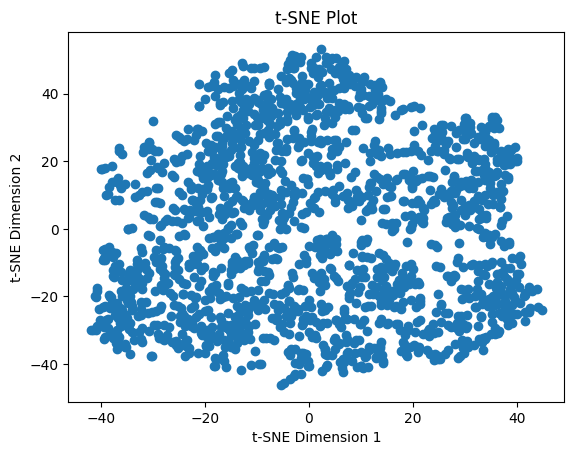

In [10]:
import matplotlib.pyplot as plt
# Plot t-SNE
plt.scatter(df_imp['coor_x'], df_imp['coor_y']) # c= df_imp['Replication']
plt.title('t-SNE Plot')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

### Create interactive tsne plot

In [11]:
import sys
from poodle.utils import tsne as tsn

l_cat = [col for col in df_categoric_replication.columns if col not in ['PATNR']]

df_imp['Replication'] = df_imp['Replication'].astype(float)
df_imp = df_imp.fillna(0)

l_cat_spec = ['RF']
l_cat_spec.extend(l_cat)
#l_cat_spec = l_cat_spec[:-3]
#l_cat_spec.append('patnr')
l_cat_spec.append('Replication')
l_cat_spec.append('PATNR')
l_cat_spec.append('PhenoGraph_clusters')
l_cat_spec.pop(-8)


# Save embedding + projection
#df_z.to_csv('../example_data/embedding/SharedProductSpace_embedding_Replication.csv', index=False, sep=',')

# Important to start with RF -> (why i do not knwo)

tsn.visualize_umap_bokeh(X_embedded, df_imp[l_cat_spec],  l_cat_spec, l_binary=l_cat_spec, patient_id='PATNR', cluster_id='Replication', title='MMAE_UMAP2',  path='../tsne/IMPROVED_MMAE.html')

1716 1716
0 []

UMAP figure saved under location: TSNE/Baseline_MMAE_UMAP2.html


In [12]:
df_z = pd.read_csv('../example_data/embedding/SharedProductSpace_embedding_Replication.csv', sep=',')
df_z

,PATNR,LF0,LF1,LF2,LF3,LF4,LF5,LF6,LF7
0,304828067_0,11.732230,0.0,6.783835,3.963366,2.020875,15.791579,12.004609,5.323130
1,304835496_0,17.045584,0.0,6.383278,3.544554,5.727974,14.939727,8.271380,7.730008
2,304837810_0,9.257213,0.0,1.088041,1.727758,4.535937,6.607569,9.996820,4.846362
3,304871478_0,14.358731,0.0,4.989531,7.317452,1.230787,3.251011,23.046082,10.560888
4,304835849_0,8.512773,0.0,6.754573,5.075659,1.413905,7.654975,12.833100,7.487601
...,...,...,...,...,...,...,...,...,...
1711,12001,4.865254,0.0,3.058719,3.429510,9.393557,7.743942,2.067103,4.467565
1712,12003,11.430490,0.0,9.782090,5.703693,4.743174,6.757173,3.491193,5.480636
1713,12005,6.855743,0.0,3.026122,2.918677,4.903226,3.646033,4.660390,5.558112
1714,12007,5.935258,0.0,2.750307,3.927422,7.251476,11.892174,3.548447,5.888910


## #3 Classify novel instances (POODLE)

### #3.1 Initialize variables for patient assignment

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

df_cluster = df_meta[['pseudoId','PhenoGraph_clusters']].copy()

# Construct patient similarity matrix from original set
sim_matrix = cosine_similarity(z_filtered.astype(np.float32))

# Specify columns for each modality (need to be present in both original & replication space)
d_input = {'cat' : list(df_categoric_replication[lcat].columns), 'num' : list(df_numeric_replication[lnum].columns)}

# Intialize list to save location of newly projected patients
z_new = []

# Define cluster
CLUSTER_LABEL = 'PhenoGraph_clusters'

# Initialize dataframe where we collect all predictors of interest for assigning patients to a cluster 
archetype_columns = ['weight_pval', 'weight_mean', 'weight_sd', 'cluster_mean_pat', 'cluster_sd_pat'] # + latent factors?
l_col = ['pseudoId', CLUSTER_LABEL]
for i in range(len(np.unique(df_cluster[CLUSTER_LABEL]))):
    l_col.extend(['%s_%s' % (col, i) for col in archetype_columns ])

df_characteristics = pd.DataFrame(columns=l_col)

### #3.2 Project the patients onto latent space and see how they are oriented

In [15]:
import multiprocessing
import sys
sys.path.append(r'../')
from poodle import utils as pup

# Bookmark identifier (use fake)
df_id = pd.DataFrame({'pseudoId' : ['id_' + str(i) for i in range(len(df_numeric_replication))]})

def orient(ix):
    print(str(ix) + ' ')
    new_pat = str(df_id.iloc[ix]['pseudoId'])
    sample_cat = df_categoric_replication[lcat].iloc[ix]
    sample_num = df_numeric_replication[lnum].iloc[ix]
    #sample =  sample_cat.append(sample_num)
    sample = pd.concat([sample_cat, sample_num], axis=0)
    sample.name = new_pat

    # create metadata
    df_meta = pup.getMetaDataPatient(df_cluster, list(df_cluster['pseudoId'].values), new_pat)
    
    l_orientation = [df_id.iloc[ix]['pseudoId'], -1]
    
    # What is the orientation of the patient compared to each cluster
    # In other words, which cluster has the largest gravity on the patient
    l_orientation.extend(pup.getOrientation(autoencoder, df_meta, pd.DataFrame(z_filtered, columns=l_embedding[1:]), d_input, sample, sim_matrix=sim_matrix, cluster_label='PhenoGraph_clusters'))

    # Bookmark cluster characteristics
    return l_orientation
    

from concurrent.futures import ThreadPoolExecutor


if __name__ == "__main__":
    with ThreadPoolExecutor(max_workers=4) as executor:
        results = list(executor.map(orient, range(len(df_id['pseudoId']))))
        
# Initialize dataframe where we collect all predictors of interest for assigning patients to a cluster 
archetype_columns = ['weight_pval', 'weight_mean', 'weight_sd', 'cluster_mean_pat', 'cluster_sd_pat'] # + latent factors?
l_col = ['pseudoId', CLUSTER_LABEL]


for i in range(len(np.unique(df_cluster[~df_cluster[CLUSTER_LABEL].isin([-1])][CLUSTER_LABEL]))):
    l_col.extend(['%s_%s' % (col, i) for col in archetype_columns ])

df_characteristics = pd.DataFrame(results, columns=l_col) 

df_characteristics.to_csv('../example_data/replication/ClusterCharacteristics_Projection.csv', index=False, sep=',')

0 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 
31 
32 
33 
34 
35 
36 
37 
38 
39 
40 
41 
42 
43 
44 
45 
46 
47 
48 
49 
50 
51 
52 
53 
54 
55 
56 
57 
58 
59 
60 
61 
62 
63 
64 
65 
66 
67 
68 
69 
70 
71 
72 
73 
74 
75 
76 
77 
78 
79 
80 
81 
82 
83 84 

85 
86 
87 
88 
89 
90 
91 
92 
93 
94 
95 
96 
97 
98 
99 
100 
101 
102 
103 
104 
105 
106 
107 
108 
109 
110 
111 
112 
113 
114 
115 
116 
117 
118 
119 
120 
121 
122 
123 
124 
125 
126 
127 
128 
129 
130 
131 
132 
133 
134 
135 
136 
137 
138 
139 
140 
141 
142 
143 
144 
145 
146 
147 
148 
149 
150 
151 
152 
153 
154 
155 
156 
157 
158 
159 
160 
161 
162 
163 
164 
165 
166 
167 
168 
169 
170 
171 
172 
173 
174 
175 
176 
177 
178 
179 
180 
181 
182 
183 
184 
185 
186 
187 
188 
189 
190 
191 
192 
193 
194 
195 
196 
197 
198 
199 
200 
201 
202 
203 
204 
205 
206 
207 
208 
209 
210 
211 
212 
213 
214 
215 
216 
217 
218 
219 
220 
221 


### #3.3 Build Poodle classifier

#### #3.3.1 Quantify orientation of original samples with respect to clusters

In [16]:
import pandas as pd
import numpy as np
from math import exp
from scipy.stats import ttest_ind
from scipy.spatial.distance import cosine# cosine minkowski
from sklearn.metrics.pairwise import cosine_similarity
import sys
#sys.path.append(r'/exports/reum/tdmaarseveen/Poodle')
from poodle import utils as pup
#import importlib as imp
#imp.reload(pup)
CLUSTER_LABEL = 'PhenoGraph_clusters'
# Initialize similarity matrix
# We only need to calculate the pairwise similarities of the initial space 1 time
sim_matrix = cosine_similarity(z_filtered.astype(np.float32))

df_characteristics_original = pup.quantifySimilarity(df_cluster, sim_matrix, CLUSTER_LABEL = 'PhenoGraph_clusters')
    
# Bookmark cluster characteristics
df_characteristics_original['pseudoId'] = df_cluster['pseudoId'].copy()
df_characteristics_original[CLUSTER_LABEL] = df_cluster[CLUSTER_LABEL].copy()
df_characteristics_original.to_csv('../example_data/development/ClusterCharacteristics_Original.csv', index=False, sep=',')
df_characteristics_original.head()

,pseudoId,PhenoGraph_clusters,weight_pval_0,weight_mean_0,weight_sd_0,cluster_mean_pat_0,cluster_sd_pat_0,weight_pval_1,weight_mean_1,weight_sd_1,...,weight_pval_2,weight_mean_2,weight_sd_2,cluster_mean_pat_2,cluster_sd_pat_2,weight_pval_3,weight_mean_3,weight_sd_3,cluster_mean_pat_3,cluster_sd_pat_3
0,304828067_0,0,1.000000e+00,0.877835,0.080889,0.897699,0.067501,5.417478e-14,0.919341,0.047614,...,1.237714e-49,0.901194,0.056025,0.826012,0.076308,0.044433,0.809763,0.115468,0.798154,0.110860
1,304835496_0,1,1.000000e+00,0.877930,0.080842,0.892882,0.053574,1.000000e+00,0.919186,0.047634,...,2.817121e-13,0.901194,0.056025,0.874436,0.063757,0.000133,0.809763,0.115468,0.787067,0.100086
2,304837810_0,3,9.617493e-01,0.877930,0.080842,0.884186,0.071464,8.596338e-35,0.919341,0.047614,...,3.057389e-53,0.901194,0.056025,0.827496,0.071092,0.927616,0.809690,0.115511,0.819505,0.109207
3,304871478_0,3,3.017604e-51,0.877930,0.080842,0.788843,0.104590,4.499401e-147,0.919341,0.047614,...,6.541644e-125,0.901194,0.056025,0.689027,0.097250,0.137725,0.809824,0.115415,0.801629,0.122127
4,304835849_0,0,9.999688e-01,0.877856,0.080853,0.893234,0.077066,8.440296e-71,0.919341,0.047614,...,2.611294e-53,0.901194,0.056025,0.821781,0.076537,1.000000,0.809763,0.115468,0.864904,0.098110


#### #3.3.2 Optimize weights with simple classifier

TRAIN: [222 223 224 225 226 227 228 229 230 231] TEST: [0 1 2 3 4 5 6 7 8 9]
[17:53:36] WARNING: ../src/learner.cc:767: 
Parameters: { "n_trees" } are not used.

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [222 223 224 225 226 227 228 229 230 231]
[17:53:36] WARNING: ../src/learner.cc:767: 
Parameters: { "n_trees" } are not used.

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [444 445 446 447 448 449 450 451 452 453]
[17:53:36] WARNING: ../src/learner.cc:767: 
Parameters: { "n_trees" } are not used.

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [666 667 668 669 670 671 672 673 674 675]
[17:53:36] WARNING: ../src/learner.cc:767: 
Parameters: { "n_trees" } are not used.

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [888 889 890 891 892 893 894 895 896 897]
[17:53:36] WARNING: ../src/learner.cc:767: 
Parameters: { "n_trees" } are not used.



Text(0.5, 1.0, 'Confusion matrix for the Poodle labeler (XGB) on trainingsset (ACC: 1.00)')

<Figure size 640x480 with 0 Axes>

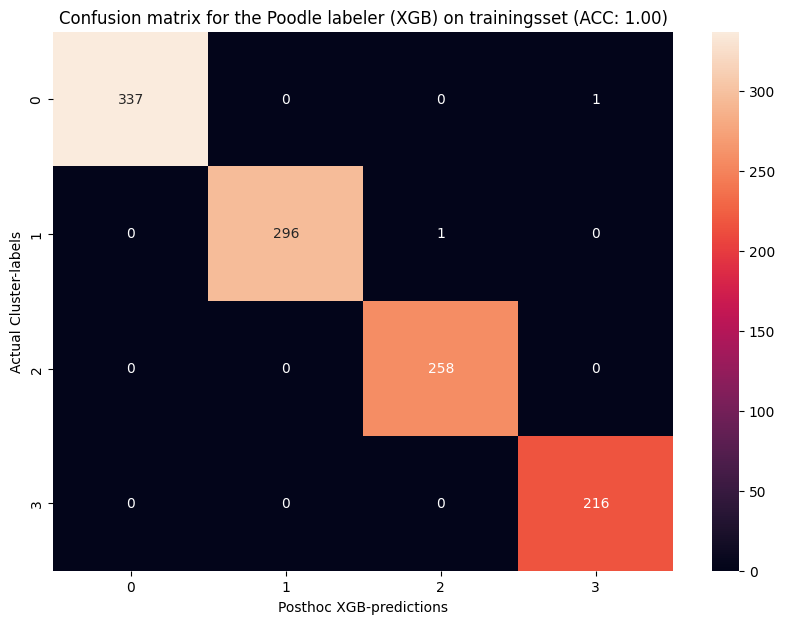

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb
import matplotlib.pyplot as plt
import time
import seaborn as sn
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

df_train, df_test = train_test_split(df_characteristics_original, test_size=0.2,  random_state=28072022) # stratify=df_characteristics['PhenoGraph_clusters'],

target = 'PhenoGraph_clusters'

cols_data = [x for x in list(df_train.columns) if x not in ['pseudoId', target]] #   'Sex', 'Age', 

X = df_train[cols_data].values
y = df_train[target]

# Apply 5 fold CV
kf = KFold(n_splits=5) # 
iteration = 0
y_pred = []
y_proba = []

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index[:10], "TEST:", test_index[:10])
    X_train, X_test = pd.DataFrame(X).loc[train_index], pd.DataFrame(X).loc[test_index]
    y_train, y_test = np.take(y, np.array(train_index)),np.take(y, np.array(test_index))#.values  # .values

    # Z-score scaling
    scaler = StandardScaler().fit(X_train)
    X_train= scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Model is an XGBClassifier
    n_trees = 50
    dmat_train = xgb.DMatrix(X_train, y_train)
    dmat_test = xgb.DMatrix(X_test, y_test)
    
    t0 = time.time()
    xgb_clf = xgb.XGBClassifier(objective='multi:softmax', eval_metric='merror', num_class=len(y.unique()), n_trees=50)
    xgb_clf = xgb_clf.fit(X_train, y_train)

    
    t1 = time.time()
    iteration += 1
    
    # Create a confusion matrix over all data!
    #y_pred.extend(bst.predict(dmat_test))
    y_proba.extend(xgb_clf.predict_proba(X_test))
    y_pred.extend(xgb_clf.predict(X_test))
    
fig = plt.figure()
cm = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)


df_cm = pd.DataFrame(cm, index = list(range(len(y.unique()))),
                  columns = list(range(len(y.unique()))))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel("Posthoc XGB-predictions")
plt.ylabel("Actual Cluster-labels")
plt.title('Confusion matrix for the Poodle labeler (XGB) on trainingsset (ACC: %.2f)' % (accuracy))

#### #3.3.3 Show performance on hold-out test set

Text(0.5, 1.0, 'Confusion matrix for the Poodle labeler (XGB) in independent test set (ACC: 1.00)')

<Figure size 640x480 with 0 Axes>

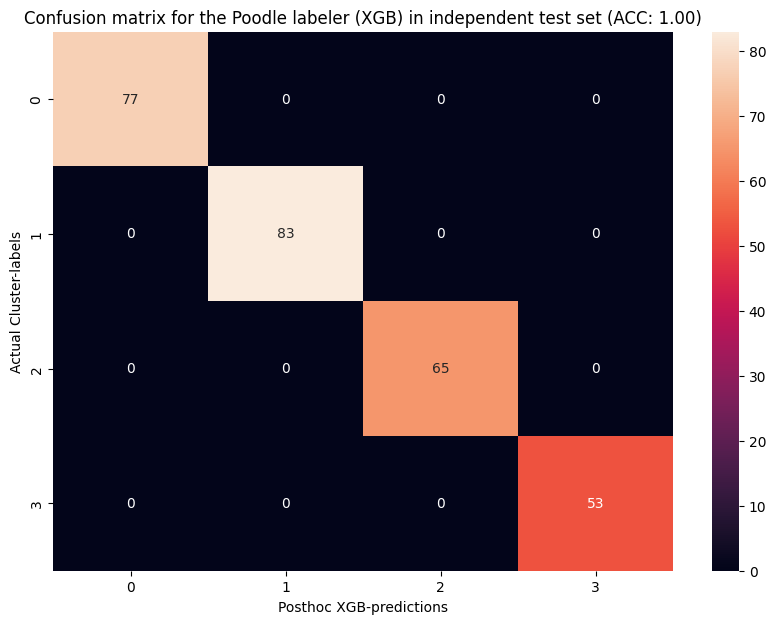

In [18]:
X_test_final = df_test[cols_data].values
y_test_final = df_test[target]

# Z-score scaling
#scaler = StandardScaler().fit(X_test)
X_test_final = scaler.transform(X_test_final)
y_pred_final = xgb_clf.predict(X_test_final)


fig = plt.figure()
cm = confusion_matrix(y_test_final, y_pred_final)
accuracy = accuracy_score(y_test_final, y_pred_final)


df_cm = pd.DataFrame(cm, index = list(range(len(y_test_final.unique()))),
                  columns = list(range(len(y_test_final.unique()))))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel("Posthoc XGB-predictions")
plt.ylabel("Actual Cluster-labels")
plt.title('Confusion matrix for the Poodle labeler (XGB) in independent test set (ACC: %.2f)' % (accuracy))

#### #3.3.4 Compare to dummy classifier

Text(0.5, 1.0, 'Confusion matrix for the Dummy labeler (XGB) in independent test set (ACC: 0.58)')

<Figure size 640x480 with 0 Axes>

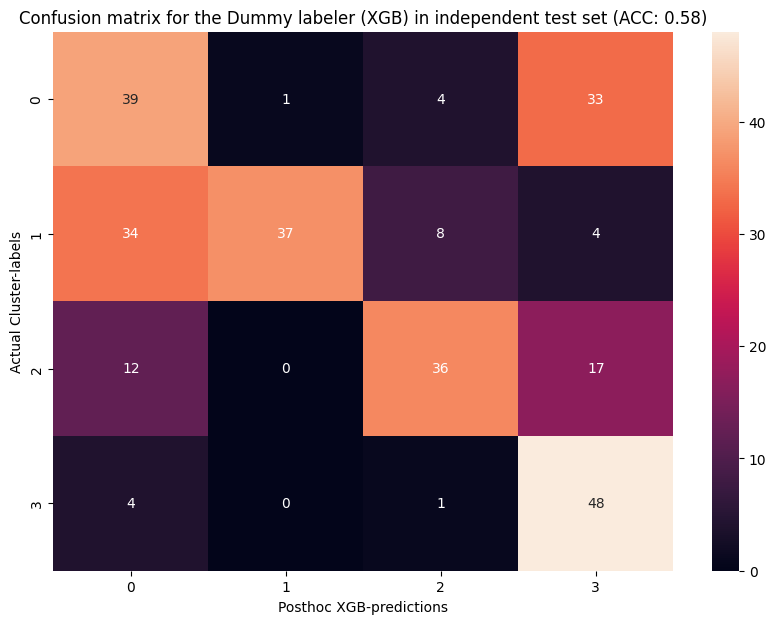

In [19]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score

def dummyLabeler(X):
    return np.argmax(X) # largest p

target = 'PhenoGraph_clusters'

X = df_test[[col for col in df_test.columns if 'weight_pval' in col]].copy()
y = df_test[target]

y_pred = []

for ix in range(len(X)): # loop through patients
    y_pred.append(dummyLabeler(X.iloc[ix]))

fig = plt.figure()
cm = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)

df_cm = pd.DataFrame(cm, index = list(range(len(y.unique()))),
                  columns = list(range(len(y.unique()))))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel("Posthoc XGB-predictions")
plt.ylabel("Actual Cluster-labels")
plt.title('Confusion matrix for the Dummy labeler (XGB) in independent test set (ACC: %.2f)' % (accuracy))

#### #3.3.5 Train final model on all labeled data & Save model

In [20]:
from sklearn.model_selection import KFold
import xgboost as xgb
import matplotlib.pyplot as plt

import time
import seaborn as sn
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from pickle import dump

X_all = df_characteristics_original[cols_data]
y_all = df_characteristics_original[CLUSTER_LABEL]

scaler = StandardScaler().fit(X_all)

X_all = scaler.transform(X_all)

dmat_train = xgb.DMatrix(X_all, y_all)

t0 = time.time()
bst  = xgb.train({'objective': 'multi:softmax',  'eval_metric':'merror', 'num_class':len(y.unique())}, dmat_train, # 'num_class':len(y.unique())
                    n_trees, evals=[(dmat_train, "train")]) # "tree_method": "gpu_hist", 'gamma': 8, , (dmat_test, "test")
t1 = time.time()

# save poodle labeler
bst.save_model("../example_data/model/labeler/xgb_model.json")

# save scaler
dump(scaler, open('../example_data/model/labeler/scaler.pkl', 'wb'))


[0]	train-merror:0.00000
[1]	train-merror:0.00000
[2]	train-merror:0.00000
[3]	train-merror:0.00000
[4]	train-merror:0.00000
[5]	train-merror:0.00000
[6]	train-merror:0.00000
[7]	train-merror:0.00000
[8]	train-merror:0.00000
[9]	train-merror:0.00000
[10]	train-merror:0.00000
[11]	train-merror:0.00000
[12]	train-merror:0.00000
[13]	train-merror:0.00000
[14]	train-merror:0.00000
[15]	train-merror:0.00000
[16]	train-merror:0.00000
[17]	train-merror:0.00000
[18]	train-merror:0.00000
[19]	train-merror:0.00000
[20]	train-merror:0.00000
[21]	train-merror:0.00000
[22]	train-merror:0.00000
[23]	train-merror:0.00000
[24]	train-merror:0.00000
[25]	train-merror:0.00000
[26]	train-merror:0.00000
[27]	train-merror:0.00000
[28]	train-merror:0.00000
[29]	train-merror:0.00000
[30]	train-merror:0.00000
[31]	train-merror:0.00000
[32]	train-merror:0.00000
[33]	train-merror:0.00000
[34]	train-merror:0.00000
[35]	train-merror:0.00000
[36]	train-merror:0.00000
[37]	train-merror:0.00000
[38]	train-merror:0.00

### #3.4 Use POODLE to cluster new instances

In [21]:
import sys
sys.path.append(r'../')
from poodle import utils as pup
import pandas as pd
from pickle import load


df_new = pd.read_csv('../example_data/replication/ClusterCharacteristics_Projection.csv', sep=',')

#df_new = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/ClusterCharacteristics_Projection_IMPROVED.csv', sep=',')


# Define input columns
target = 'PhenoGraph_clusters'
cols_data = [x for x in list(df_new.columns) if x not in ['pseudoId', target]]

# Classify patients
X_replication = df_new[cols_data]#.

# load the scaler
scaler = load(open('../example_data/model/labeler/scaler.pkl', 'rb'))
#X_replication = scaler.transform(X_replication)

df_new['PhenoGraph_clusters'] = pup.classifyPatient(X_replication, path="../example_data/model/labeler/")
df_new.to_csv('../example_data/results/ClusterAssignment_IMPROVED_repl.csv', index=False, sep=',')
df_new.head()

,pseudoId,PhenoGraph_clusters,weight_pval_0,weight_mean_0,weight_sd_0,cluster_mean_pat_0,cluster_sd_pat_0,weight_pval_1,weight_mean_1,weight_sd_1,...,weight_pval_2,weight_mean_2,weight_sd_2,cluster_mean_pat_2,cluster_sd_pat_2,weight_pval_3,weight_mean_3,weight_sd_3,cluster_mean_pat_3,cluster_sd_pat_3
0,id_0,2.0,1.00000,0.87793,0.080842,0.915158,0.056329,0.000001,0.919341,0.047614,...,0.996134,0.901194,0.056025,0.908187,0.046613,1.000000,0.809763,0.115468,0.878790,0.077034
1,id_1,2.0,0.96529,0.87793,0.080842,0.883058,0.057041,0.000001,0.919341,0.047614,...,1.000000,0.901194,0.056025,0.920166,0.042063,0.700088,0.809763,0.115468,0.812201,0.075310
2,id_2,0.0,0.00002,0.87793,0.080842,0.859852,0.088358,0.000001,0.919341,0.047614,...,0.000001,0.901194,0.056025,0.804888,0.085085,0.001880,0.809763,0.115468,0.788115,0.120840
3,id_3,0.0,1.00000,0.87793,0.080842,0.895006,0.065231,0.000001,0.919341,0.047614,...,0.000001,0.901194,0.056025,0.860417,0.061231,0.999999,0.809763,0.115468,0.838373,0.097603
4,id_4,1.0,1.00000,0.87793,0.080842,0.894521,0.054666,1.000000,0.919341,0.047614,...,0.000001,0.901194,0.056025,0.874341,0.059645,0.256859,0.809763,0.115468,0.805794,0.098870


### update cluster assignment information

In [22]:
import sys
#sys.path.append(r'../')
#sys.path.append(r'/exports/reum/tdmaarseveen/Poodle')
from poodle import utils as pup
import pandas as pd
import numpy as np

df_z = pd.read_csv('../example_data/embedding/SharedProductSpace_embedding_Replication.csv', sep=',')
l_embedding = [col for col in df_z.columns]

# Variables from replication set
df_projection = pd.read_csv('../example_data/results/ClusterAssignment_IMPROVED_repl.csv', sep=',')

# import metadata of SyG replication set
df_meta_new = pd.read_csv('../example_data/total/ClusteringTOTAL_INFO.csv', sep='|')
df_meta_new = df_meta_new[df_meta_new['Replication']==1].copy()
df_meta_new = df_meta_new.reset_index(drop=True)

# add cluster info for projected patietns
df_meta_new['PhenoGraph_clusters'] = df_projection['PhenoGraph_clusters'].copy() # len(metadata['PhenoGraph_clusters'].unique())+1

# import metadata of development set
df_meta = pd.read_csv('../example_data/development/ClusteringDEV_INFO.csv', sep=',')
#metadata_RA = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/MMAE_clustering_270.csv', index_col=0) #  pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_metadata.csv')
df_meta['Replication'] = 0

# Combine both metadatas
df_meta_full = df_meta.append(df_meta_new, ignore_index = True)

# Add projected patients to original set
l_latent = [col for col in l_embedding if col not in ['pseudoId', 'PATNR']]

print('BEFORE: total samples for tsne: ', len(df_meta))
metadata_total, z_total = pup.add_projected_patients(df_meta, pd.DataFrame(z_filtered, columns=l_latent), df_meta_new, z_patient[l_latent]) # ix = 
print('After: total samples for tsne: ', len(df_meta_full))

# Add clusters to cluster assignment file
metadata_total.to_csv('../example_data/results/ClusterAssignment_IMPROVED.csv', sep=';', index=None)

/tmp/ipykernel_476650/2403603890.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_meta_full = df_meta.append(df_meta_new, ignore_index = True)


BEFORE: total samples for tsne:  1387
After: total samples for tsne:  1716


### #3.5 [OPTIONAL] Assign outliers to restgroups

In [23]:
import pandas as pd

lf_col = ['LF0', 'LF1', 'LF2', 'LF3', 'LF4', 'LF5', 'LF6', 'LF7' ] # 'LF0', 'LF1', 'LF2', 'LF3', 'LF4', 'LF5', 'LF6', 'LF7'

df_id = df_meta_full[['pseudoId', 'PhenoGraph_clusters', 'Replication']].reset_index(drop=True)
df_orient = df_id.merge(df_z[lf_col], left_index=True, right_index=True)

outliers_n = pup.identifyOutliers(df_orient, std_factor=3, repl_label='Replication')
df_meta_full['Outlier'] = df_meta_full['pseudoId'].isin(outliers_n)
df_meta_full['Outlier']

In [24]:
outliers_n

['304847181_0',
 '304824140_0',
 '304841862_0',
 '304861691_0',
 '304837750_0',
 '304843812_0',
 '304833561_0',
 '304826439_0',
 '304863045_0',
 '304817812_0',
 '4004',
 '304833585_0',
 '304818519_0',
 '304853304_0',
 '304844615_0',
 '304828080_0',
 '304836248_0',
 '304827584_0']

0       False
1       False
2       False
3       False
4       False
        ...  
1711    False
1712    False
1713    False
1714    False
1715    False
Name: Outlier, Length: 1716, dtype: bool

### #3.6 Visualize spatial variance

In [26]:
import pandas as pd
df_new = pd.read_csv('../example_data/results/ClusterAssignment_IMPROVED_repl.csv', sep=',')

# Original clustering information (same samples as development set)
df_cluster = df_meta[['pseudoId', 'PhenoGraph_clusters']].copy()

Spatial variance in replication set: 	C1= 78; C2= 111; C3= 58; C4= 82
Spatial variance in original set: 	C1= 415; C2= 380; C3= 323; C4= 269


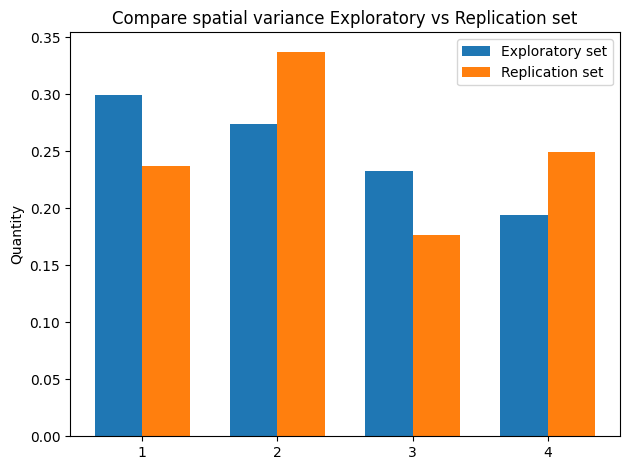

In [27]:
from collections import Counter
import sys
sys.path.append(r'/exports/reum/tdmaarseveen/Poodle')
from poodle import visualization as viz

c = Counter(df_new['PhenoGraph_clusters'])
l_new = [c[ix]/sum(c.values()) for ix in range(0,len(c))]
print('Spatial variance in replication set: \tC' + '; C'.join([str(ix+1) + '= ' + str(c[ix]) for ix in range(0,len(c))]))
c = Counter(df_cluster['PhenoGraph_clusters'])
l_old = [c[ix]/sum(c.values()) for ix in range(0,4)]
print('Spatial variance in original set: \tC' + '; C'.join([str(ix+1) + '= ' + str(c[ix]) for ix in range(0,4)]))

viz.plotSpatialVariation(l_new, l_old)

## #4 Visualize joint involvement patterns per cluster

In [28]:
import importlib as imp
import sys
sys.path.append(r'/exports/reum/tdmaarseveen/RA_Clustering/src/1_emr_scripts')
import MannequinFunctions as func
imp.reload(func)

<module 'MannequinFunctions' from '/exports/reum/tdmaarseveen/RA_Clustering/src/1_emr_scripts/MannequinFunctions.py'>

In [ ]:
CLUSTER =1
CATEGORY = 'Zwelling' # 'Zwelling'
# Import mannequin information
df_man = df_meta_full[df_meta_full['Replication']==1].copy()
df_man['PhenoGraph_clusters'] = df_new['PhenoGraph_clusters'].copy()
df_cluster['PATNR']=df_cluster['pseudoId'].copy()
l_pat = set(df_man[df_man['PhenoGraph_clusters']==CLUSTER]['PATNR'])
df_sub = df_man[df_man['PATNR'].isin(l_pat)].copy()

#create scatterplot (toDo: for both big & small joints)
#l_col = [col for col in df_sub.columns if col not in ['pseudoId', 'patnr','FirstConsult', 'PATNR']]
l_mannequin = [col for col in df_imp.columns if ((('Zwelling_' in col or 'Pijn_' in col)) and 'positive' in col)]
l_col = [col for col in l_mannequin ] #if CATEGORY in col
df_plot = pd.DataFrame(df_sub[l_col].mean().T)
df_plot= df_plot.reset_index()
df_plot.columns = ['feature', 'value']
df_plot['x'], df_plot['y'], df_plot['s'] = zip(*df_plot['feature'].apply(lambda x : func.get_mannequin_coord(x)))
df_plot['s'] = df_plot['s'] #* df_plot['value']

# Visualize gestalt
im = plt.imread('/exports/reum/tdmaarseveen/RA_Clustering/figures/2_processing/Mannequin_large_old.jpg')
implot = plt.imshow(im)
plt.scatter(df_plot.x, df_plot.y, s=df_plot.s, c=df_plot.value, cmap='autumn_r')
fig = plt.gcf()
fig.set_dpi(100)
#plt.text(450, 1, r'Cluster %s' % str(CLUSTER+1), fontsize=15)
plt.axis('off')

### #3.6 Visualize Learned embedding

In [33]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Define the encoder model
def create_encoder(input_dim, latent_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(64, activation='sigmoid')(input_layer) # sigmoid
    x = Dense(32, activation='sigmoid')(x)
    x = Dense(16, activation='sigmoid')(x)
    latent_space = Dense(latent_dim)(x)  # No activation in the output layer

    return Model(input_layer, latent_space, name='encoder')
 
# Parameters
input_dim = 8
latent_dim = 2  # Target dimension for UMAP

encoder = create_encoder(input_dim, latent_dim)
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 34        
Total params: 3,218
Trainable params: 3,218
Non-trainable params: 0
_________________________________________________________________


In [34]:
from umap.parametric_umap import ParametricUMAP
import importlib as imp

keras_fit_kwargs = {"callbacks": [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        min_delta=10**-4,
        patience=10,
        verbose=1,
    )
]}

SEED = 20240506 # 
#SEED = 202405421 # 

embedder = ParametricUMAP(random_state=SEED, keras_fit_kwargs=keras_fit_kwargs, encoder=encoder, n_training_epochs=10) #
embedding = embedder.fit_transform(z_filtered)
tsn.plot_tsne(embedding, group_id=df_meta['PhenoGraph_clusters'], path='../figures/original/tsne_original_clusters.png')
# example_data/model/umap/umap_mapping
# save parametric UMAP
embedder.save('../example_data/model/umap/umap_mapping')

/exports/reum/tdmaarseveen/envs/mmae/envs/ae_training/lib/python3.8/site-packages/umap/parametric_umap.py:269: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  warn(


Epoch 1/100
18/18 [==============================] - 1s 30ms/step - loss: 4.3445
Epoch 2/100
18/18 [==============================] - 1s 30ms/step - loss: 2.8932
Epoch 3/100
18/18 [==============================] - 1s 30ms/step - loss: 2.0388
Epoch 4/100
18/18 [==============================] - 1s 30ms/step - loss: 1.4908
Epoch 5/100
18/18 [==============================] - 1s 30ms/step - loss: 1.1483
Epoch 6/100
18/18 [==============================] - 1s 30ms/step - loss: 0.9300
Epoch 7/100
18/18 [==============================] - 1s 30ms/step - loss: 0.7875
Epoch 8/100
18/18 [==============================] - 1s 30ms/step - loss: 0.7021
Epoch 9/100
18/18 [==============================] - 1s 30ms/step - loss: 0.6365
Epoch 10/100
18/18 [==============================] - 1s 30ms/step - loss: 0.5891
Epoch 11/100
18/18 [==============================] - 1s 30ms/step - loss: 0.5452
Epoch 12/100
18/18 [==============================] - 1s 30ms/step - loss: 0.5167
Epoch 13/100
18/18 [=====

In [35]:
# Project replication data onto tSNE
fit2 = embedder.transform(z_total.values)

# Plot Umap as 2d image
tsn.plot_tsne(embedding, group_id=df_meta['Replication'], path='../figures/original/tsne_original.png')
tsn.plot_tsne(fit2, group_id=df_meta_full['Replication'], path='../figures/replication/tsne_replication_projected.png')


Product space (2D representation)            |  Newly projected patients on product space
:-------------------------:|:-------------------------:
![tsne_original](../figures/original/tsne_original.png)  |  ![tsne_replicate](../figures/replication/tsne_replication_projected.png)
![tsne_original_cluster](../figures/original/tsne_original_clusters.png)  |  

#### Show where outliers are projected!

In [38]:
tsn.plot_tsne(fit2, group_id=df_meta_full['Outlier'], path='../figures/replication/tsne_replication_outliers.png')

## Show inter-cluster vs intra-cluster distance distribution

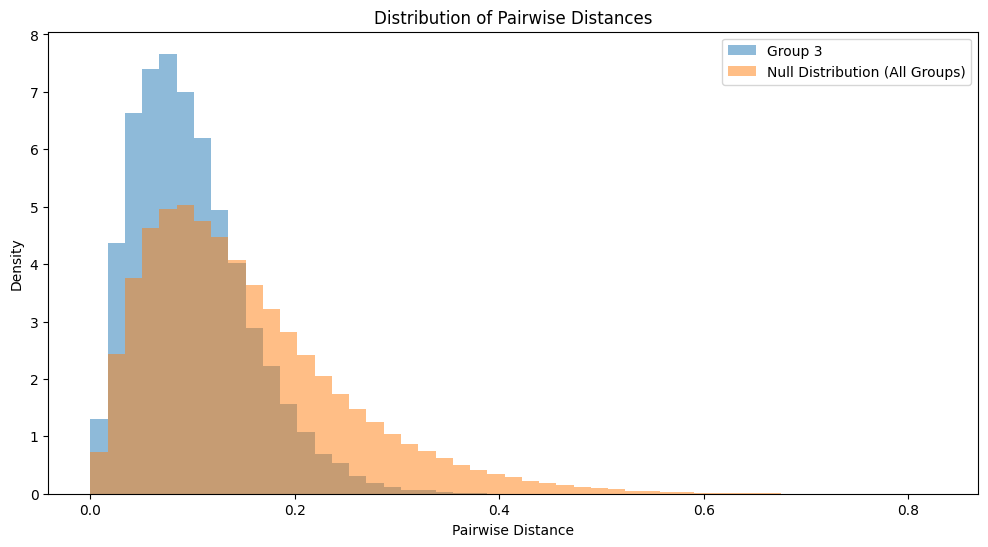

K-S statistic: 0.2498896329683853
P-value: 0.0


In [39]:
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, squareform 
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, ttest_ind
from scipy.stats import mannwhitneyu

CLUSTER = 2
METRIC = 'cosine'
 # 'LF1', 'LF2',
lf_col = ['LF0', 'LF1', 'LF2', 'LF3', 'LF4', 'LF5', 'LF6', 'LF7' ] # 'LF0', 'LF1', 'LF2', 'LF3', 'LF4', 'LF5', 'LF6', 'LF7'
df_original = df_cluster.copy()
df_original = df_original.merge(df_z[lf_col], left_index=True, right_index=True)

# Filter Group 1
group1 = df_original[df_original['PhenoGraph_clusters'] == CLUSTER][lf_col].values

# Calculate pairwise distances within Group 1
#distances_group1 = distance.mahalanobis(
distances_group1 = pdist(group1, metric=METRIC)
distances_group1 = squareform(distances_group1)
distances_group1 = distances_group1[np.triu_indices_from(distances_group1, k=1)]

# Use all points
all_points = df_original[df_original['PhenoGraph_clusters'] != CLUSTER][lf_col].values

# Calculate pairwise distances for all points
distances_all = pdist(all_points, metric=METRIC)
distance_matrix_all = squareform(distances_all)#distance_matrix_all = squareform(distances_all)
distances_all = distance_matrix_all[np.triu_indices_from(distance_matrix_all, k=1)]

# Determine common bin edges
min_distance = min(distances_group1.min(), distances_all.min())
max_distance = max(distances_group1.max(), distances_all.max())
bins = np.linspace(min_distance, max_distance, 50)

# Plotting
plt.figure(figsize=(12, 6))

# Plot for Group 1
plt.hist(distances_group1, bins=bins, alpha=0.5, label='Group %s' % (CLUSTER + 1), density=True)

# Plot for Null Distribution
plt.hist(distances_all, bins=bins, alpha=0.5, label='Null Distribution (All Groups)', density=True)

plt.xlabel('Pairwise Distance')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution of Pairwise Distances')
plt.show()

# Perform K-S test
statistic, p_value = ks_2samp(distances_group1, distances_all)

# Print the results
print(f"K-S statistic: {statistic}")
print(f"P-value: {p_value}")


In [40]:
std_factor = 3

centroid = np.mean(df_original[df_original['PhenoGraph_clusters'] == CLUSTER][lf_col].values, axis=0)
cluster_samples = df_original[df_original['PhenoGraph_clusters'] == CLUSTER][lf_col].values

outliers = []
# intra cluster
intra_cluster_distances = [np.linalg.norm(sample - centroid) for sample in cluster_samples]
mean_distance = np.mean(intra_cluster_distances)
std_distance = np.std(intra_cluster_distances)
outliers.extend([ix for ix, sample, dist in zip(range(len(cluster_samples)), cluster_samples, intra_cluster_distances)
            if dist > mean_distance + std_factor * std_distance])
outliers_n = [df_original[df_original['PhenoGraph_clusters'] == CLUSTER]['pseudoId'].iloc[i] for i in outliers]
outliers_n

['304844615_0', '304828080_0', '304836248_0']

In [96]:

def identifyOutliers(df_orient, std_factor=3, cluster_label='PhenoGraph_clusters', prefix_lf='LF', id_label='pseudoId'): 
    """
    Description: 
         Identify outliers within each cluster (according to the standard deviation)
    
    Input: 
        df_orient = dataframe with id, clus+ter information and latent factors
        std_factor= standard deviation cut-off used to define outliers 
        cluster_label = name of colum with cluster label
        prefix_lf =  prefix to recognize latent factor coordinates (default: LF)
        id_label = name of colum with id label (default: pseudoId)
    
    Output: 
        outliers_n = list of sample ids of the outliers
    """
    lf_col = [col for col in df_orient.columns if prefix_lf in col]
    
    outliers_n = []
    for c in df_orient[cluster_label].unique():
        # Get cluster samples and centroids
        centroid = np.mean(df_orient[df_orient[cluster_label] == c][lf_col].values, axis=0)
        cluster_samples = df_orient[df_orient[cluster_label] == c][lf_col].values

        # calculate intra cluster distance 
        intra_cluster_distances = [np.linalg.norm(sample - centroid) for sample in cluster_samples]
        mean_distance = np.mean(intra_cluster_distances)
        std_distance = np.std(intra_cluster_distances)
        
        # Identify deviants by predefined cut_off
        outliers = []
        outliers.extend([ix for ix, sample, dist in zip(range(len(cluster_samples)), cluster_samples, intra_cluster_distances)
            if dist > mean_distance + std_factor * std_distance])
        
        outliers_n.extend([df_orient[df_orient[cluster_label] == c][id_label].iloc[i] for i in outliers])
    return outliers_n
        



['304865295_0',
 '304853487_0',
 '304860361_0',
 '304841416_0',
 '304843812_0',
 '304868031_0',
 '304866346_0',
 '304817812_0',
 '2104',
 '7019',
 '304853027_0',
 '304835846_0',
 '304828080_0',
 '304832545_0']

In [99]:
other_centroids

[array([7.7844057 , 7.18262078, 7.0314078 , 4.54393161, 5.45840231,
        4.45052554]),
 array([ 6.76415341, 12.17643093,  7.83953859,  4.32944787,  3.71570942,
         4.83520424]),
 array([6.48245861, 4.23883975, 5.61264275, 4.65293474, 6.17270724,
        3.91588522]),
 array([ 4.64333174, 11.24655357,  8.70176839,  4.94734228,  8.41909298,
         5.23580379])]

In [98]:

# Get cluster samples and centroids
centroid = np.mean(df_original[df_original['PhenoGraph_clusters'] == CLUSTER][lf_col].values, axis=0)
cluster_samples = df_original[df_original['PhenoGraph_clusters'] == CLUSTER][lf_col].values

# intercluster distance
outliers = []
other_centroids= [np.mean(df_original[df_original['PhenoGraph_clusters'] == c][lf_col].values, axis=0) for c in df_original['PhenoGraph_clusters'].unique()]
df_centroid = pd.DataFrame(columns = ['C%s' % i for i in range(len(other_centroids)) ])

for sample in cluster_samples :
    inter_cluster_distances = [np.linalg.norm(sample - other_centroid) for other_centroid in other_centroids]
    df_centroid.loc[len(df_centroid)] = inter_cluster_distances
    if min(inter_cluster_distances) < np.linalg.norm(sample - centroid):
        outliers.append(sample)
len(outliers)

69

In [237]:

# Calculate the actual minimum of A, B, and C for each row
df_centroid['actual_min'] = df_centroid[['C%s' % i for i in range(len(other_centroids)) ]].min(axis=1)

# Find rows where Min_Col does not equal the calculated minimum
mismatch_rows = df_centroid[df_centroid['intra'] != df_centroid['actual_min']]
mismatch_rows

,C0,C1,C2,C3,C4,intra,actual_min
0,8.172349,9.114332,11.314199,10.696990,7.253723,8.172349,7.253723
1,5.029485,10.628965,3.524500,10.658731,11.151634,5.029485,3.524500
2,8.208319,9.977316,7.125028,9.411060,14.565340,8.208319,7.125028
6,5.208676,8.761145,3.532182,8.966420,11.812527,5.208676,3.532182
10,11.797161,13.243163,14.396261,14.001927,9.815980,11.797161,9.815980
...,...,...,...,...,...,...,...
405,5.958990,7.851357,5.629673,8.788153,12.919589,5.958990,5.629673
408,7.842305,9.833446,8.517301,6.985094,10.281170,7.842305,6.985094
409,8.132418,10.620742,10.348490,10.406837,4.667484,8.132418,4.667484
411,4.090201,8.764089,4.057464,8.144125,9.581363,4.090201,4.057464


In [238]:
from scipy.spatial.distance import mahalanobis

# Assuming you have the covariance matrix
inv_cov_matrix = np.linalg.inv(np.cov(cluster_samples))
#centroid = np.mean(pd.DataFrame(cluster_samples), axis=0)
mahalanobis_distances = [mahalanobis(sample, centroid, inv_cov_matrix) for sample in pd.DataFrame(cluster_samples).values]
outliers = [sample for sample, dist in zip(cluster_samples, mahalanobis_distances)
            if dist > threshold]  # Define a threshold

ValueError: shapes (6,) and (415,415) not aligned: 6 (dim 0) != 415 (dim 0)

## Old function

In [ ]:
def projectSample(model, z_space, d_input, sample, prefix_lf='LF'): # sample
    """
    Input:
        model = Loaded autoencoder object with the learned product space (Tensorflow model)
        z_space = product space (based on original set)
        d_input = dictionary featuring columns in the original space for each modality
        sample = features of 1 patient from the replication set
        prefix_lf =  prefix to recognize latent factor coordinates (default: LF)
        
    Description: 
    Project new sample onto the product space by employing previously trained MAUI model.
    We also make sure to look at the same latent factors as before!
    """
    
    sample_cat = sample[d_input['cat']].copy()
    sample_num = sample[d_input['num']].copy()   
    new_pat = sample.name
    
    df_cat = pd.DataFrame(columns=list(sample_cat.index))
    df_cat.loc[0] = sample_cat
    
    df_num = pd.DataFrame(columns=list(sample_num.index))
    df_num.loc[0] = sample_num
    
    # Project new sample in product space
    if hasattr(model, "transform"):
        z_patient = model.transform({ 'Categorical': df_cat.T, 'Lab_numerical': df_num.T})
    elif hasattr(model, "encoder"):
        z_patient = model.encoder.predict([np.array(df_cat.values), np.array(df_num.values)], batch_size=256)
        z_patient = pd.DataFrame(z_patient)
    
        z_patient.columns = [prefix_lf + '%s' % col for col in z_patient.columns]
                             
    
    # Add Merged factors
    l_merged = [col for col in z_space.columns if '_' in str(col)]
    for col in l_merged: 
        i, j = col.split('_')[0], col.split('_')[1]
        z_patient[col] =  z_patient[[prefix_lf + '%s' % i, prefix_lf + '%s' % j]].mean(axis=1)
    
    #print('ZPAT:', z_patient, '\nZSPACE:', z_space)
    
    # Only select relevant latent factors
    z_patient = z_patient[z_space.columns]
    
    # Add new patient to product space
    z_space = pd.concat([z_space, z_patient], ignore_index=True)
    return z_space


def similarityToCluster(df, sim_matrix, cluster_ix=0, cluster_label='PhenoGraph_clusters', output_dist=False):
    """
    Description:
        Calculate the distances of a new patient to a specific cluster (cluster_ix), and 
        compare this distribution (distance of new patient vs all patients of cluster) to 
        the within cluster similarity (all pairwise distances of said cluster).

    Input:
        df = pandas dataframe containing the metadata
        sim_matrix = distance/similarity matrix 
        new_pat = patient of interest
        cluster_ix = the cluster of interest
        cluster_label = name of cluster columns
        output_dist = set to True if you want to get the raw cluster/ patient distances
            
    Output: 
        list of predictors expressing the relationship between the sample and the cluster
    
    """
    # Get the indices of patients from specific cluster
    cluster_indices = list(df[df[cluster_label]==cluster_ix].index)

    # Add the new patient
    patient_indices = cluster_indices.copy()
    patient_indices.append(len(sim_matrix)-1)

    # Subset similarity matrix on said cluster
    sim_matrix_cluster = pd.DataFrame(sim_matrix.copy()).loc[patient_indices, patient_indices]

    # Patient vs cluster
    patient_scores = list(sim_matrix_cluster[len(sim_matrix)-1])
    patient_scores = sorted(patient_scores, reverse=True)
    patient_scores = patient_scores[1:] # remove comparison with self

    # Within cluster
    sim_matrix_cluster = np.array(pd.DataFrame(sim_matrix_cluster).loc[cluster_indices, cluster_indices])
    # Keep scores of all unique pairwise distances within cluster
    mask = np.triu(np.ones_like(sim_matrix_cluster, dtype=bool),1) # 1 below diagonal
    cluster_scores =  np.array(sim_matrix_cluster[mask])

    # Perform one tailed t-test
    tstat, pval = pup.t_test(patient_scores, cluster_scores, alternative='less')

    # Define predictors (Be aware: we assume a normal distribution)
    pred_0 = max(0.000001, pval) #pval # H0 = patient is similar to cluster, Ha = patient is not similar
    pred_1 = np.mean(cluster_scores) # average cluster probability
    pred_2 = np.std(cluster_scores) # stability of the cluster
    pred_3 = np.mean(patient_scores) # average patient probability
    pred_4 = np.std(patient_scores) # stability of patient probability
    
    if output_dist == False: 
        # Return predictors for model
        return [pred_0, pred_1, pred_2, pred_3, pred_4]
    else : 
        # Return predictors for model
        return patient_scores, cluster_scores

def getOrientation(model, df_meta, z_existent, d_input, sample, sim_matrix=None, cluster_label='PhenoGraph_clusters', prefix_lf='LF'):
    """
    Description: 
    Discover the orientation of the sample on the learned embedding and quantify its similarity to each cluster
    
    In other words: Compare each novel instance to all other 'old' instances

    Input: 
        prefix_lf =  prefix to recognize latent factor coordinates (default: LF)
    
    Output: 
        l_orientation = list that features predictors expressing the relationship 
            between the sample and each cluster 
        df_meta = metadata of original sample population + newly projected sample
    
    """
    # Debug: check if there are identifiers -> distance calculation will break for that that 
    if len(list(z_existent[[i.sum()==0 for i in z_existent.values]].index)) > 0:
        print('(Negative control failed) Samples w/ only zeroes in latent space: ', list(z_existent[[i.sum()==0 for i in z_existent.values]].index))
    
    
    # Bookmark all orientation info
    l_orientation = []
    z_updated = projectSample(model, z_existent.copy(),  d_input, sample, prefix_lf)
    
    
    
    # We only need to calculate the pairwise similarities of the initial space 1 time
    if type(sim_matrix) == type(None) :
        # Construct similarity matrix
        sim_matrix = cosine_similarity(z_updated[:-1].astype(np.float32))

    # Create duplicate
    sim_matrix_child = sim_matrix.copy()
    sim_matrix_child = pd.DataFrame(sim_matrix_child)

    # Calculate distance of projected patient to other patients
    
    l_dist = [1-cosine(z_updated.iloc[-1].values, z_updated.loc[i].values) for i in range(len(z_updated))]

    # Add to distance matrix
    sim_matrix_child.loc[len(sim_matrix_child)] = l_dist[:-1]
    sim_matrix_child[len(sim_matrix_child)-1] = l_dist
    
    n_clusters = len(df_meta[cluster_label][:-1].unique()) # ignore final row (because it is the projected patient)
    
    for cluster_ix in range(n_clusters): 
        # Calculate similarity to each cluster
        sim_scores = similarityToCluster(df_meta, sim_matrix_child, cluster_ix, cluster_label=cluster_label)
        l_orientation.extend(sim_scores)
    return l_orientation